In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# **Load the MNIST dataset**

In [2]:
mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Convert X to a NumPy array
X = np.array(X)

In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **Data Preprocessing**

In [6]:
X = X / 255.0
X = X.reshape(-1, 28, 28)  # Reshape the images to 28x28

In [7]:
X.shape

(70000, 28, 28)

# **Data Visualization**

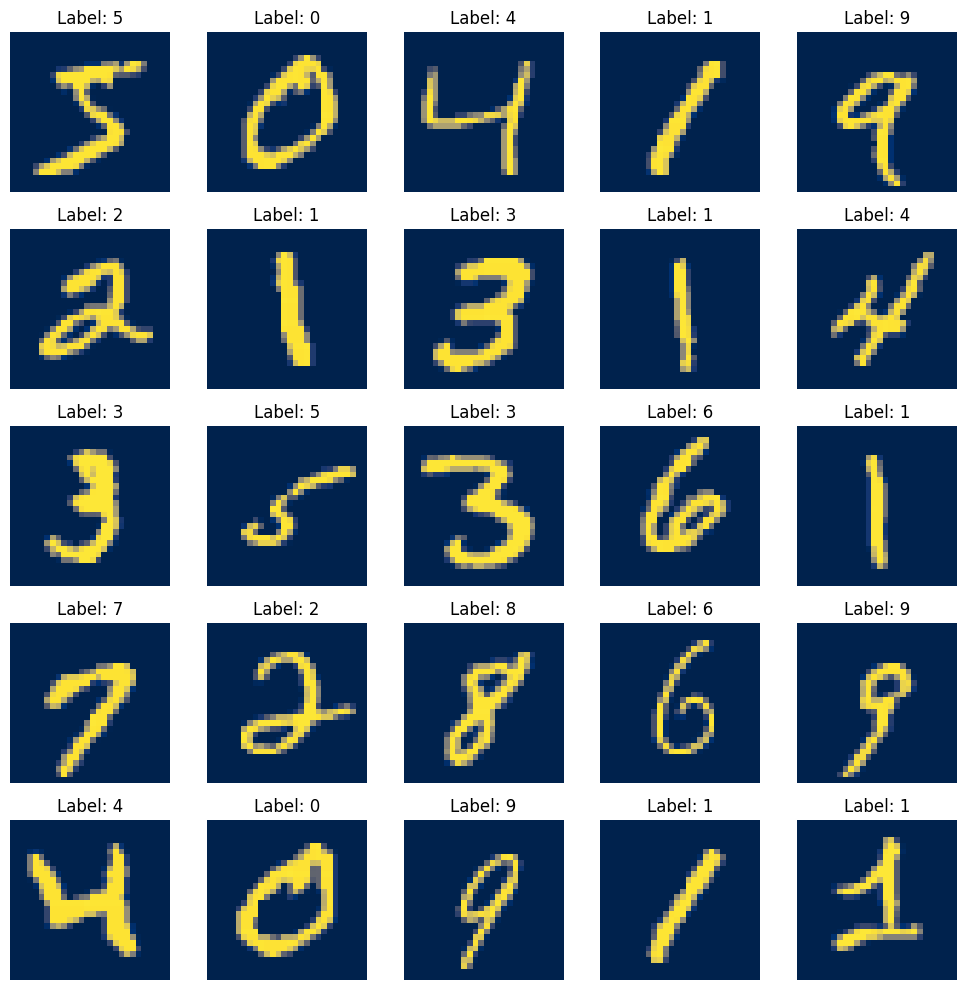

In [45]:
# Visualize the original images with labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[i], cmap='cividis')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

# **Feature Extraction using Chain Code**

In [26]:
def chain_code(image):
    contours = find_contours(image, 0.5)
    if len(contours) == 0:
        return np.zeros(8)
    contour = contours[0]
    dx = np.diff(contour[:, 1])
    dy = np.diff(contour[:, 0])
    directions = np.array([np.arctan2(dy_, dx_) for dx_, dy_ in zip(dx, dy)])
    bin_edges = np.linspace(-np.pi, np.pi, 9)
    chain = np.histogram(directions, bins=bin_edges)[0]
    return chain

In [28]:
def extract_features(images, block_size=(3, 3)):
    h_blocks, w_blocks = block_size
    block_h_size = images.shape[1] // h_blocks
    block_w_size = images.shape[2] // w_blocks
    features = []
    for image in images:
        feature_vector = []
        for i in range(h_blocks):
            for j in range(w_blocks):
                block = image[i*block_h_size:(i+1)*block_h_size, j*block_w_size:(j+1)*block_w_size]
                feature_vector.extend(chain_code(block))
        features.append(feature_vector)
    return np.array(features)

In [29]:
block_size = (3, 3)
X_chain_codes = extract_features(X, block_size)

In [30]:
X_chain_codes

array([[0., 1., 0., ..., 0., 1., 2.],
       [0., 0., 0., ..., 0., 1., 2.],
       [0., 0., 1., ..., 4., 4., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

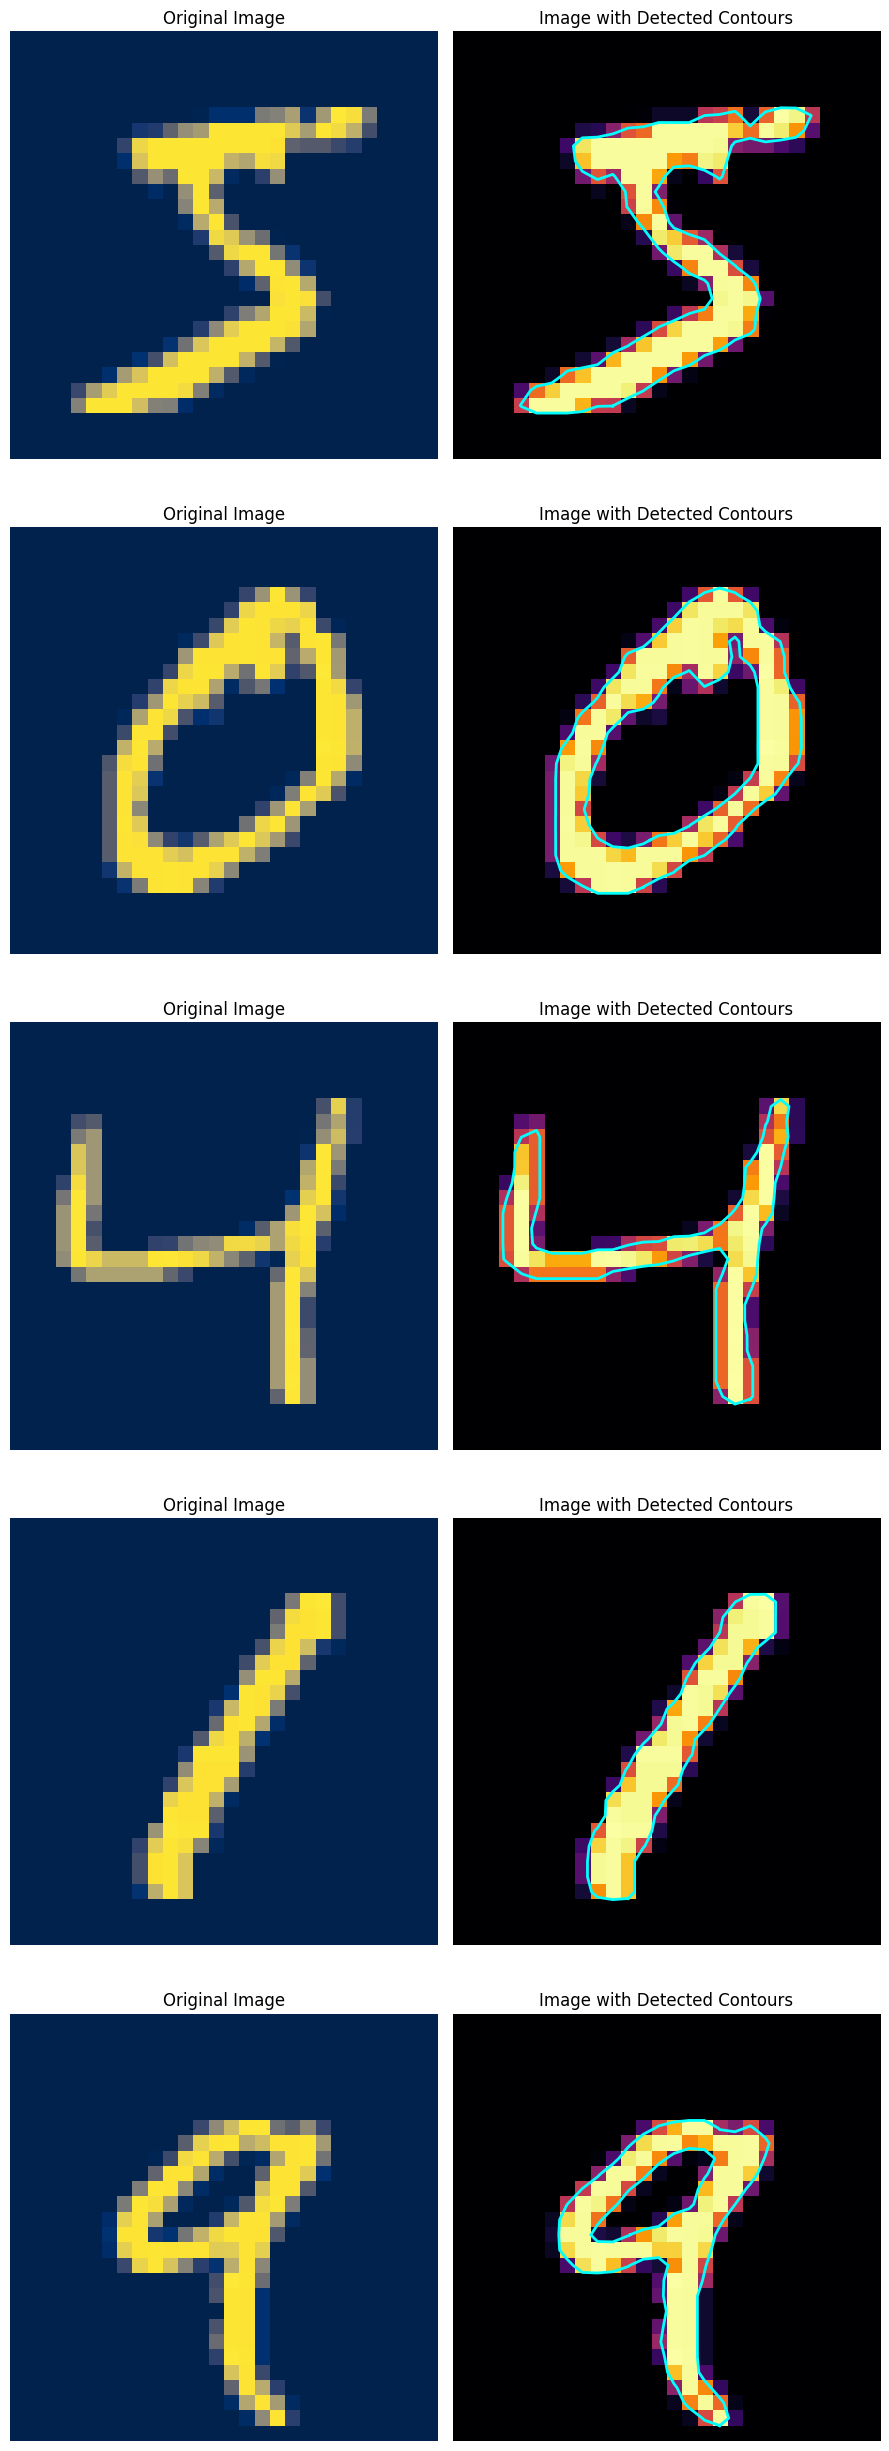

In [44]:
def plot_example_images_with_boundaries(X, block_size=(3, 3), n_images=5):
    fig, axs = plt.subplots(n_images, 2, figsize=(9, n_images * 5))
    for i in range(n_images):
        axs[i, 0].imshow(X[i], cmap='cividis')  # Using 'cividis' colormap for original image
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        contours = find_contours(X[i], 0.5)
        axs[i, 1].imshow(X[i], cmap='inferno')  # Using 'inferno' colormap for image with detected contours
        for contour in contours:
            axs[i, 1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='cyan')  # Contour color: cyan
        axs[i, 1].set_title('Image with Detected Contours')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the updated visualization
plot_example_images_with_boundaries(X, n_images=5)


# **Split Data into train and Test**

In [32]:
# Split dataset into train and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X_chain_codes, y, test_size=0.3, random_state=42)

In [33]:
X_train.shape

(49000, 72)

# **Classification**

In [34]:
# Train a classifier
clf = KNeighborsClassifier()
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

KNeighborsClassifier()

In [35]:
# Evaluate the classifier
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9052380952380953


In [36]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9215


In [39]:
# Train a Support Vector Machine classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [40]:
# Evaluate the SVM classifier
y_pred_svm = svm_clf.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')

SVM Accuracy: 0.9380


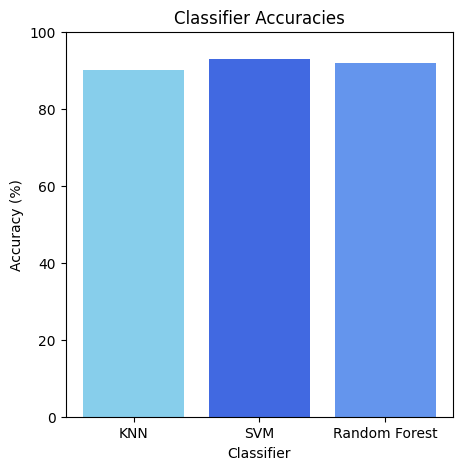

In [48]:
# Accuracy values
accuracies = [90, 93, 92]
classifiers = ['KNN', 'SVM', 'Random Forest']

# Define colors from the blue family
colors = ['skyblue', 'royalblue', 'cornflowerblue']

# Plotting the accuracies
plt.figure(figsize=(5, 5))
plt.bar(classifiers, accuracies, color=colors)
plt.title('Classifier Accuracies')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Setting y-axis limit from 0 to 100 for percentage accuracy
plt.show()


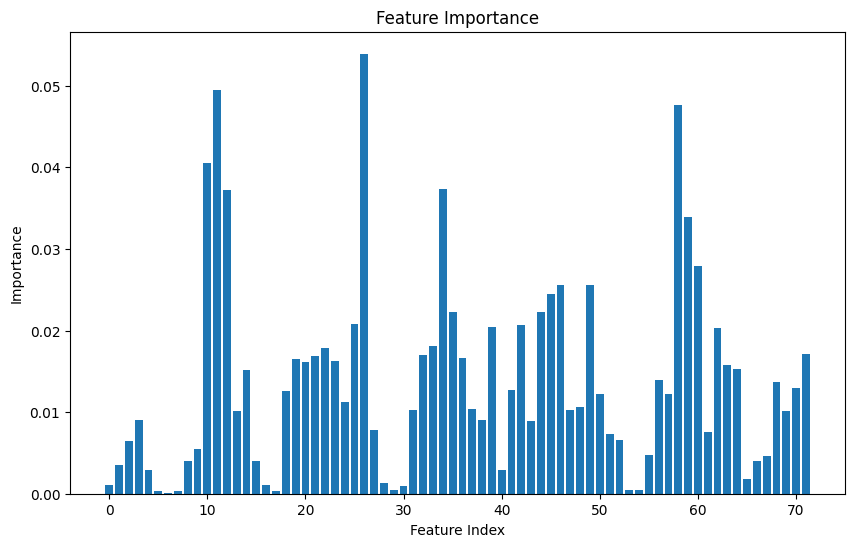

In [53]:
# Feature Importance (for Random Forest Classifier)
if isinstance(clf, RandomForestClassifier):
    feature_importance = clf.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.show()